In [1]:
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from library.preprocessing import new_Processing_before_journal

# Getting Folders

In [2]:
all_folders=glob.glob("./Trails/*/*/")

test_dates=['2019-06-28','2019-06-30','2019-07-01','2019-07-02','2019-07-03','2019-07-04','2019-07-05']
formatted_test_dates=['-'.join(d.split("-")[::-1]) for d in test_dates] #reversing order

#train folders
train_folders=[f for f in all_folders if f.split("/")[-2].split("_")[0] not in formatted_test_dates]

#test folders
test_folders=[f for f in all_folders if f.split("/")[-2].split("_")[0] in formatted_test_dates]

# Loading Models

In [3]:
with open('./logs/rfs.pickle', 'rb') as handle:
    rfs = pickle.load(handle)

/home/prasenjit/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/prasenjit/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Features

In [4]:
#feature # binding
F=\
    {1:'stay_duration', #f1
     2:'mfcc0',3:'mfcc1',4:'mfcc2',5:'mfcc3',6:'mfcc4', #f2,f3,f4,f5,f6
     7:'wifi_count', 8:'edge_wifi_count', #f7,f8
     9:'RSI', #f9
     10:'human_made', 11:'natural_land',12:'road_exist_percent',13:'highly_populated_poi_exist'#f10,f11,f12,f13
    }

selected_feat=\
    {
        'Is_Bus_stop':[F[e] for e in [10,12,11,1,8]],
        'Is_Turn':[F[e] for e in [10,12,11,1,8,9]],
        'Is_Signal':[F[e] for e in [12,11,10,8,9]],
        'Is_Congestion':[F[e] for e in [2,11,10,9,12,8,6,1]],
        'Is_Adhoc':[F[e] for e in [10,11,1,12,2]]
    }

# Processing Testing DATA

In [5]:
def time_zone_cal(s):
    hour=int(s.split(':')[0])
    if 6<hour<=9:
        time_zone='Early_Morning'
    elif 9<hour<=12:
        time_zone='Morning'
    elif 12<hour<=17:
        time_zone='Afternoon'
    elif 17<hour<=23:
        time_zone='Evening'
    return time_zone

def read_trails(idx,file_path):
    trail_type='down' if 'down' in file_path else 'up'
    df=pd.read_csv(file_path)
    df['trail_type']=trail_type
    df['TZ']=df['start_time'].apply(time_zone_cal)
    df['trail_id']=idx
    return df

In [6]:
we_need=['trail_type','TZ','trail_id','lat','long','medical','other_poi', 'park', 'school', 'Is_Adhoc_pred']

df_raw= pd.concat([read_trails(idx,folder+"All_DATA.csv") for idx,folder in enumerate(test_folders)])\
                .reset_index(drop=True)
df_processed = new_Processing_before_journal(dataframe=df_raw)

for poi_column in rfs.keys():
    feature_names=selected_feat[poi_column]
    test_data = df_processed[feature_names].values
    prediction=rfs[poi_column].predict(test_data)
    print('f1_score:',poi_column,f1_score(df_processed[poi_column].values,prediction,average='weighted'))
    df_raw[poi_column+'_pred']=prediction

df=df_raw[we_need].copy()
df.columns=['trail_type', 'TZ', 'trail_id', 'lat', 'long', 'medical', 'other_poi',
            'park', 'school', 'Is_Adhoc']

f1_score: Is_Bus_stop 0.8494750441983406
f1_score: Is_Turn 0.8242587608280021
f1_score: Is_Signal 0.9318570674719782
f1_score: Is_Congestion 0.8487339766384451
f1_score: Is_Adhoc 0.7181938333221106


In [7]:
#Markets
from geopy.distance import geodesic

# Params should be tuples of format: (lattitude, longitude)
def distance(pointA, pointB):
    return geodesic(pointA, pointB).meters

markets=pd.read_csv("../1. DataProcessing/markets.csv")[['lat','long']].values

def inMarket(cord,within=300):
    for lat,long in markets:
        if distance((cord[0],cord[1]),(lat,long))<within:
            return 1
    return 0

#Making all PoIs as boolean variables (1- exist 0- does not exist)
df['inMarket']=df[['lat','long']].apply(lambda cord: inMarket(cord),axis=1)
df['medical']=df['medical'].apply(lambda e: 1 if e>0 else 0)
df['school']=df['school'].apply(lambda e: 1 if e>0 else 0)
df['park']=df['park'].apply(lambda e: 1 if e>0 else 0)
#Other_PoI=>  attraction,business,government,place_of_worship,sports_complex
df['other_poi']=df['other_poi'].apply(lambda e: 1 if e>0 else 0)
df['noPoI']=((df['inMarket']!=1) & (df['medical']!=1) & (df['school']!=1) & (df['park']!=1) & (df['other_poi']!=1)).apply(np.int32)
# #New dataframe
df_new=df[['inMarket','medical','school','park','other_poi','noPoI','Is_Adhoc']].copy()
df_need=df_new.copy()
df_new=df_new[df_new.Is_Adhoc==1].copy()
df_new['Is_Adhoc']=df_new.Is_Adhoc.cumsum().apply(lambda e:f'adhoc_{e}')

<AxesSubplot:>

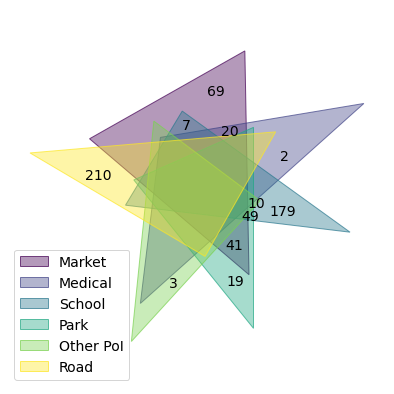

In [8]:
from itertools import product

num_elem=[]
setA=[];setB=[];setC=[];setD=[];setE=[];setF=[]
for A,B,C,D,E,F in product([0,1],repeat=6):
    setA.append(A);setB.append(B);setC.append(C);setD.append(D);setE.append(E);setF.append(F)
    filter=\
        (df_new['inMarket']==A) & (df_new['medical']==B) & (df_new['school']==C) & \
        (df_new['park']==D) & (df_new['other_poi']==E) & (df_new['noPoI']==F)
    count=df_new[filter].shape[0]
    num_elem.append(count)

df_set=pd.DataFrame({'Market':setA,'Medical':setB,'School':setC,'Park':setD,'Other PoI':setE,'Road':setF,'numElem':num_elem})
df_set=df_set[df_set.numElem>0].copy()

from collections import Counter
sets = Counter()
for A,B,C,D,E,F,N in df_set.values:
    sets[f'{A}{B}{C}{D}{E}{F}']=N
    
labels=list(df_set.columns)[:-1]

from venn import draw_venn, generate_colors
fig=plt.figure(figsize=(11,7))
ax=fig.add_subplot(111)
draw_venn(
    petal_labels=sets, dataset_labels=labels,
    hint_hidden=False, colors=generate_colors(n_colors=6),figsize=None,
    fontsize=14, legend_loc="best", ax=ax)

#fig.savefig("../4. MotivationPlots/plots/num_adloc_vs_poi_venn.png")

In [9]:
df_set['Percentage']=(df_set.numElem/df_set.numElem.sum())*100
#df_set.to_csv("Adhoc_venn_test_data.csv",index=False)
df_set

,Market,Medical,School,Park,Other PoI,Road,numElem,Percentage
1,0,0,0,0,0,1,210,34.482759
2,0,0,0,0,1,0,3,0.492611
4,0,0,0,1,0,0,19,3.119869
8,0,0,1,0,0,0,179,29.392447
10,0,0,1,0,1,0,10,1.642036
12,0,0,1,1,0,0,49,8.045977
16,0,1,0,0,0,0,2,0.328407
32,1,0,0,0,0,0,69,11.330049
36,1,0,0,1,0,0,41,6.732348
40,1,0,1,0,0,0,7,1.149425


In [10]:
34.48+0.49+3.12+29.39+1.64+8.05+0.33+11.33+6.73+1.15+3.28

99.99

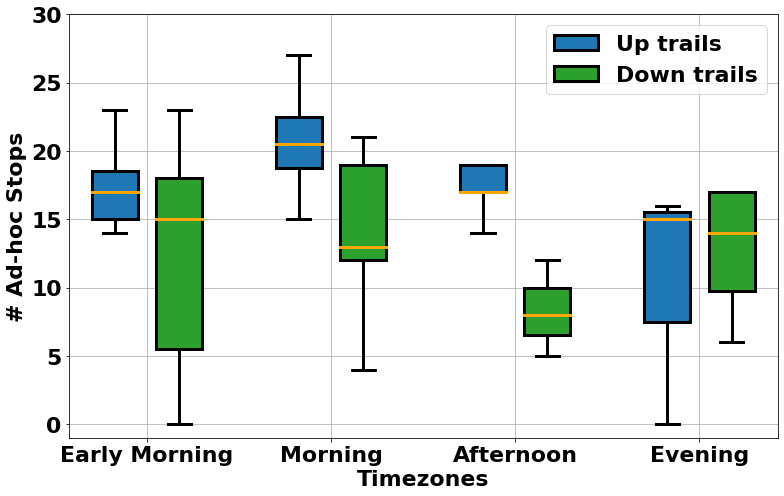

In [11]:
fig, ax = plt.subplots(figsize=(11,7))

pos=[1,3,5,7]
sep=0.7

adhoc_up=df[df['trail_type']=='up'].groupby(['TZ','trail_id'])['Is_Adhoc'].sum()
bp1=\
ax.boxplot([adhoc_up['Early_Morning'],adhoc_up['Morning'],adhoc_up['Afternoon'],adhoc_up['Evening']],
            positions=pos,
            showfliers=False,notch=False,patch_artist=True, 
            boxprops=dict(linewidth=3.0,color='black',facecolor="C0"),
            whiskerprops = dict(linestyle='-',linewidth=3.0, color='black'),
            capprops=dict(linestyle='-',linewidth=3.0, color='black'),
            medianprops=dict(linestyle='-',linewidth=3.0, color='orange')
          )

adhoc_down=df[df['trail_type']=='down'].groupby(['TZ','trail_id'])['Is_Adhoc'].sum()
bp2=\
ax.boxplot([adhoc_down['Early_Morning'],adhoc_down['Morning'],adhoc_down['Afternoon'],adhoc_down['Evening']],
            positions=[e+sep for e in pos],
            showfliers=False,notch=False,patch_artist=True, 
            boxprops=dict(linewidth=3.0,color='black',facecolor="C2"),
            whiskerprops = dict(linestyle='-',linewidth=3.0, color='black'),
            capprops=dict(linestyle='-',linewidth=3.0, color='black'),
            medianprops=dict(linestyle='-',linewidth=3.0, color='orange')
          )

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Up trails', 'Down trails'],
          prop={'size':22,'weight':'bold'},loc='upper right')

ax.set_xlabel("Timezones",fontsize=22, fontweight='bold')
ax.set_ylabel("# Ad-hoc Stops",fontsize=22, fontweight='bold')

ax.set_xticks([1.35,3.35,5.35,7.35])
ax.set_ylim(-1,30)
ax.set_xticklabels(['Early Morning','Morning','Afternoon','Evening'],fontsize=22, fontweight='bold')
plt.yticks(fontsize=22, fontweight='bold')
plt.tight_layout()
plt.grid()
fig.savefig("../4. MotivationPlots/plots/adloc_tz_trail_box_test.png")

In [9]:
#NICE